In [10]:
# import sys
# sys.path.append('/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/')

In [11]:
import networkx as nx

import matplotlib.pyplot as plt

from typing import Tuple, Union, TypeVar
from gym import Env
from gym.wrappers.monitoring.video_recorder import VideoRecorder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

import csv
import logging
import os
import time
from copy import deepcopy
from scipy import stats
import numpy as np

In [12]:
ObsType = TypeVar("ObsType")
logging.basicConfig(level=logging.INFO)

In [13]:
from src.graph.evrp_network import EVRPNetwork
from src.graph.evrp_graph import EVRPGraph

### Encoder

In [14]:
class GraphEncoder(nn.Module):
    def __init__(
        self,
        node_input_dim: int,
        embedding_dim: int = 128,
        hidden_dim: int = 512,
        num_attention_layers: int = 3,
        num_heads: int = 8,
    ):
        """
        Initalizes the GraphEncoder

        Args:
            node_input_dim (int): Feature Dimension of input nodes
            embedding_dim (int): Number of dimensions in the embedding space.
            hidden_dim (int): Number of neurons of the hidden layer of the fcl.
            num_attention_layers (int): Number of attention layers.
            num_heads (int): Number of heads in each attention layer
        """
        super().__init__()
        # initial embeds ff layer for each nodes type
        self.node_embed = nn.Linear(node_input_dim, embedding_dim)

        self.attention_layers = nn.ModuleList(
            [
                MultiHeadAttentionLayer(
                    embedding_dim=embedding_dim,
                    hidden_dim=hidden_dim,
                    num_heads=num_heads,
                )
                for _ in range(num_attention_layers)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Calculates the node embedding for each node
        in each graph.

        Args:
            x (torch.Tensor): Shape (num_graphs, num_nodes, num_features)

        Returns:
            torch.Tensor: Returns the embedding of each node in each graph.
                Shape (num_graphs, num_nodes, embedding_dim).
        """

        out = self.node_embed(x)
        for layer in self.attention_layers:
            out = layer(out)

        return out


class BatchNorm(nn.Module):
    """
    Coverts inputs of (N, L, C) to (N*L, C)
    s.t we can apply BatchNorm for the
    features C.
    """

    def __init__(self, feature_dim):
        super().__init__()
        self.norm = nn.BatchNorm1d(feature_dim)

    def forward(self, x):
        shape = x.size()
        return self.norm(x.view(-1, shape[-1])).view(*shape)


class SkipConnection(nn.Module):

    def __init__(self, module):
        super(SkipConnection, self).__init__()
        self.module = module

    def forward(self, input):
        return input + self.module(input)


class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dim: int, num_heads: int):
        """
        MultiHeadAttentionLayer with skip connection, batch
        normalization and a fully connected network.

        Args:
            embedding_dim (int): Number of dimensions in the embedding space.
            hidden_dim (int): Number of neurons of the hidden layer of the fcl.
            num_heads (int): Number of attention heads.
        """
        super().__init__()

        self.attention_layer = nn.MultiheadAttention(
            embed_dim=embedding_dim, num_heads=num_heads, batch_first=True
        )

        self.bn1 = BatchNorm(embedding_dim)
        self.bn2 = BatchNorm(embedding_dim)

        self.ff = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass

        Args:
            x (torch.Tensor): Input tensor of shape
                (num_graph, num_nodes, num_features)

        Returns:
            torch.Tensor: Output of shape
                (num_graph, num_nodes, embedding_dim)
        """
        out = self.bn1(x + self.attention_layer(x, x, x)[0]) # Skip connection and normalize
        out = self.bn2(out + self.ff(out)) # Skip connection and normalize

        return out


### Decoder

In [15]:
class GraphDecoder(nn.Module):
    """
    Decoder Class to generate node prediction.
    """

    def __init__(
        self,
        emb_dim: int = 128,
        num_heads: int = 8,
        v_dim: int = 128,
        k_dim: int = 128,
    ):
        """
        Args:
            emb_dim (int): Dimension of the input embedding.
            num_heads (int): Number of attention heads.
            v_dim (int): Dimension of attention value.
            k_dim (int): Dimension of attention key.
        """
        super().__init__()

        self._first_node = nn.Parameter(torch.rand(1, 1, emb_dim))
        self._last_node = nn.Parameter(torch.rand(1, 1, emb_dim))

        self.attention = nn.MultiheadAttention(
            embed_dim=3 * emb_dim,
            num_heads=num_heads,
            kdim=k_dim,
            vdim=v_dim,
            batch_first=True,
        )

        self._kp = nn.Linear(emb_dim, emb_dim, bias=False)
        self._att_output = nn.Linear(emb_dim * 3, emb_dim, bias=False)

        # project in context of [graph_emb, ]
        self._context_proj = nn.Linear(emb_dim * 2 + 1, emb_dim * 3, bias=False)

        self.first_ = None
        self.last_ = None
        self.first_step = True
        self.num_heads = num_heads

    def forward(
        self,
        node_embs: torch.Tensor,
        mask: torch.Tensor = None,
        load: torch.Tensor = None, # TODO
        C: int = 10,
        rollout: bool = False,
    ):
        """
        Forward method of the Decoder

        Args:
            node_embs (torch.Tensor): Node embeddings with shape (batch_size, num_nodes, emb_dim)
            mask (torch.Tensor, optional): Node mask with shape (batch_size, num_nodes). Defaults to None.
            load (torch.Tensor, optional): Load of the vehicle with shape (batch_size, 1). Defaults to None.
            C (int, optional): Hyperparameter to regularize logit calculation. Defaults to 10.
            rollout (bool, optional): Determines if prediction is sampled or maxed. Defaults to False.

        Returns:
            torch.Tensor: Node prediction for each graph with shape (batch_size, 1)
            torch.Tensor: Log probabilities
        """
        batch_size, _, emb_dim = node_embs.shape

        graph_emb = torch.mean(
            node_embs, axis=1, keepdims=True
        )  # shape (batch, 1, emb)

        if self.first_ is None:
            self.first_ = self._first_node.repeat(batch_size, 1, 1)
            self.last_ = self._last_node.repeat(batch_size, 1, 1)

        k = self._kp(node_embs)

        # Create context with first, last node and graph embedding.
        # Where last is the node from last decoding step.
        if load is None:
            context = torch.cat([graph_emb, self.first_, self.last_], -1)
        else:
            context = torch.cat([graph_emb, self.last_, load[:, None, None]], -1)
            context = self._context_proj(context)

        attn_mask = mask.repeat(self.num_heads, 1).unsqueeze(1)
        q, _ = self.attention(context, node_embs, node_embs, attn_mask=attn_mask)
        q = self._att_output(q)

        u = torch.tanh(q.bmm(k.transpose(-2, -1)) / emb_dim ** 0.5) * C
        u = u.masked_fill(mask.unsqueeze(1).bool(), float("-inf"))

        log_prob = torch.zeros(size=(batch_size,))
        nn_idx = None
        if rollout:
            nn_idx = u.argmax(-1)
        else:
            m = Categorical(logits=u)
            nn_idx = m.sample()
            log_prob = m.log_prob(nn_idx)
        temp = nn_idx.unsqueeze(-1).repeat(1, 1, emb_dim)
        self.last_ = torch.gather(node_embs, 1, temp)

        if self.first_step:
            self.first_ = self.last_
            self.first_step = False

        return nn_idx, log_prob

    def reset(self):
        """
        Resets first and last node.
        Must be called before starting a new game.
        """
        self.first_ = None
        self.last_ = None
        self.first_step = True



### Environment

In [16]:
class EVRPEnv(Env):
    """
    EVRPEnv implements the Electric Vehicle Routing Problem
    a special variant of the vehicle routing problem that decouples the trailer and the truck.

    State: Shape (batch_size, num_nodes, 4) The third
        dimension is structured as follows:
        [x_coord, y_coord, num_chargers, available_chargers, trailer, truck, visitable]

    Actions: Depends on the number of nodes, trailers and trucks in every graph.
        Should contain the truck numbers, the trailer numbers and the node numbers 
        to visit next for each graph. Shape (batch_size, 1)
    """

    metadata = {"render.modes": ["human", "rgb_array"]}

    def __init__(
        self,
        num_nodes: int = 4,
        batch_size: int = 128,
        num_draw: int = 6,
        seed: int = 69,
    ):
        """
        Args:
            num_nodes (int, optional): Number of nodes in each generated graph. Defaults to 4.
            batch_size (int, optional): Number of graphs to generate. Defaults to 128.
            num_draw (int, optional): When calling the render num_draw graphs will be rendered. 
                Defaults to 6.
            seed (int, optional): Seed of the environment. Defaults to 69.
            video_save_path (str, optional): When set a video of the interactions with the 
                environment is saved at the set location. Defaults to None.
        """
        assert (
            num_draw <= batch_size
        ), "Num_draw needs to be equal or lower than the number of generated graphs."

        np.random.seed(seed)

        self.step_count = 0
        self.num_nodes = num_nodes
        self.batch_size = batch_size

        # init video recorder
        self.draw_idxs = np.random.choice(batch_size, num_draw, replace=False)
        self.video_save_path = None

        self.generate_graphs()

    def step(self, actions: np.ndarray) -> Tuple[ObsType, float, bool, dict]:
        """
        Run the environment one timestep. It's the users responsiblity to
        call reset() when the end of the episode has been reached. Accepts
        an action and return a tuple of (observation, reward, done, info)

        Args:
            actions (nd.ndarray): Which node to visit for each graph.
                Shape of actions is (batch_size, 1).

        Returns:
            Tuple[ObsType, float, bool, dict]: Tuple of the observation,
                reward, done and info. The observation is within
                self.observation_space. The reward is for the previous action.
                If done equals True then the episode is over. Stepping through
                environment while done returns undefined results. Info contains
                may contain additions info in terms of metrics, state variables
                and such.
        """
        assert (
            actions.shape[0] == self.batch_size
        ), "Number of actions need to equal the number of generated graphs."

        self.step_count += 1

        # visit each next node
        self.visited[np.arange(len(actions)), actions.T] = 1
        traversed_edges = np.hstack([self.current_location, actions]).astype(int)
        self.sampler.visit_edges(traversed_edges)

        self.current_location = np.array(actions)

        if self.video_save_path is not None:
            self.vid.capture_frame()

        done = self.is_done()
        return (
            self.get_state(),
            -self.sampler.get_distances(traversed_edges),
            done,
            None,
        )

    def is_done(self):
        return np.all(self.visited == 1)

    def get_state(self) -> np.ndarray:
        """
        Getter for the current environment state

        Returns:
            np.ndarray: Shape (num_graph, num_nodes, 4)
            where the third dimension consists of the
            x, y coordinates, if the node is a depot,
            and if it has been visted yet.
        """

        # generate state (depots not yet set)
        state = np.dstack(
            [
                self.sampler.get_graph_positions(),
                np.zeros((self.batch_size, self.num_nodes)),
                self.generate_mask(),
            ]
        )

        # set depots in state to 1
        state[np.arange(len(state)), self.depots.T, 2] = 1

        return state

    def generate_mask(self):
        """
        Generates a mask of where the nodes marked as 1 cannot 
        be visited in the next step according to the env dynamic.

        Returns:
            np.ndarray: Returns mask for each (un)visitable node 
                in each graph. Shape (batch_size, num_nodes)
        """
        # disallow staying on a depot
        depot_graphs_idxs = np.where(self.current_location == self.depots)[0]
        self.visited[depot_graphs_idxs, self.depots[depot_graphs_idxs].squeeze()] = 1

        # allow staying on a depot if the graph is solved.
        done_graphs = np.where(np.all(self.visited, axis=1) == True)[0]
        self.visited[done_graphs, self.depots[done_graphs].squeeze()] = 0

        return self.visited

    def reset(self) -> Union[ObsType, Tuple[ObsType, dict]]:
        """
        Resets the environment. 

        Returns:
            Union[ObsType, Tuple[ObsType, dict]]: State of the environment.
        """

        self.step_count = 0
        self.generate_graphs()
        return self.get_state()

    def generate_graphs(self):
        """
        Generates a VRPNetwork of batch_size graphs with num_nodes
        each. Resets the visited nodes to 0.
        """
        self.visited = np.zeros(shape=(self.batch_size, self.num_nodes))
        self.sampler = EVRPNetwork(
            num_graphs=self.batch_size, num_nodes=self.num_nodes
        )

        # set current location to the depots
        self.depots = self.sampler.get_depots()
        self.current_location = self.depots

    def render(self, mode: str = "human"):
        """
        Visualize one step in the env. Since its batched 
        this methods renders n random graphs from the batch.
        """
        return self.sampler.draw(self.draw_idxs)

    def enable_video_capturing(self, video_save_path: str):
        self.video_save_path = video_save_path
        if self.video_save_path is not None:
            self.vid = VideoRecorder(self, self.video_save_path)
            self.vid.frames_per_sec = 1

### Model

In [17]:
class TSPModel(nn.Module):
    def __init__(
        self,
        node_dim: int,
        emb_dim: int,
        hidden_dim: int,
        num_attention_layers: int,
        num_heads: int,
    ):
        """
        The TSPModel is used in companionship with the TSPEnv
        to solve the capacited vehicle routing problem.

        Args:
            depot_dim (int): Input dimension of a depot node.
            node_dim (int): Input dimension of a regular graph node.
            emb_dim (int): Size of a vector in the embedding space.
            hidden_dim (int): Dimension of the hidden layers of the 
                ff-network layers within the graph-encoder.
            num_attention_layers (int): Number of attention layers 
                for both the graph-encoder and -decoder.
            num_heads (int): Number of attention heads in each 
                MultiHeadAttentionLayer for both the graph-encoder and -decoder.
        """
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.encoder = GraphEncoder(
            node_input_dim=node_dim,
            embedding_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        )
        self.decoder = GraphDecoder(
            emb_dim=emb_dim, num_heads=8, v_dim=emb_dim, k_dim=emb_dim
        )

        self.model = lambda x, mask, rollout: self.decoder(
            x, mask, rollout=rollout
        )  # remove encoding and make it do it once

    def forward(self, env, rollout=False) -> Tuple[float, float]:
        """
        Forward method of the model
        Args:
            env (gym.Env): environment which the agent has to solve.
            rollout (bool, optional): policy decision. Defaults to False.

        Returns:
            Tuple[float, float]: accumulated loss and log probabilities.
        """
        done = False
        state = torch.tensor(env.get_state(), dtype=torch.float, device=self.device)
        acc_loss = torch.zeros(size=(state.shape[0],), device=self.device)
        acc_log_prob = torch.zeros(size=(state.shape[0],), device=self.device)

        emb = self.encoder(x=state[:, :, :2])

        while not done:
            actions, log_prob = self.decoder(
                node_embs=emb, mask=state[:, :, 3], rollout=rollout
            )

            state, loss, done, _ = env.step(actions.cpu().numpy())

            acc_loss += torch.tensor(loss, dtype=torch.float, device=self.device)
            acc_log_prob += log_prob.squeeze().to(self.device)

            state = torch.tensor(env.get_state(), dtype=torch.float, device=self.device)

        self.decoder.reset()

        return acc_loss, acc_log_prob  # shape (batch_size), shape (batch_size)

### Agent

In [18]:
class TSPAgent:
    def __init__(
        self,
        node_dim: int = 2,
        emb_dim: int = 128,
        hidden_dim: int = 512,
        num_attention_layers: int = 3,
        num_heads: int = 8,
        lr: float = 1e-4,
        csv_path: str = "loss_log.csv",
        seed=69,
    ):
        """
        The TSPAgent is used in companionship with the TSPEnv
        to solve the traveling salesman problem.

        Args:
            node_dim (int): Input dimension of a regular graph node.
            emb_dim (int): Size of a vector in the embedding space.
            hidden_dim (int): Dimension of the hidden layers of the 
                ff-network layers within the graph-encoder.
            num_attention_layers (int): Number of attention layers 
                for both the graph-encoder and -decoder.
            num_heads (int): Number of attention heads in each 
                MultiHeadAttentionLayer for both the graph-encoder and -decoder.
            lr (float): learning rate.
            csv_path (string): file where the loss gets saved.
            seed (int): the seed.
        """
        torch.manual_seed(seed)
        np.random.seed(seed)

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.csv_path = csv_path
        self.model = TSPModel(
            node_dim=node_dim,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        ).to(self.device)

        self.target_model = TSPModel(
            node_dim=node_dim,
            emb_dim=emb_dim,
            hidden_dim=hidden_dim,
            num_attention_layers=num_attention_layers,
            num_heads=num_heads,
        ).to(self.device)

        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(
        self,
        env,
        epochs: int = 100,
        eval_epochs: int = 1,
        check_point_dir: str = "./check_points/",
    ):
        """
        Trains the TSPAgent on an TSPEnvironment.

        Args:
            env: TSPEnv instance to train on
            epochs (int, optional): Amount of epochs to train. Defaults to 100.
            eval_epochs (int, optional): Amount of epochs to evaluate the current 
                model against the baseline. Defaults to 1.
            check_point_dir (str, optional): Directiory that the checkpoints will
                be stored in. Defaults to "./check_points/".
        """
        logging.info("Start Training")
        with open(self.csv_path, "w+", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Epoch", "Loss", "Cost", "Advantage", "Time"])

        start_time = time.time()

        for e in range(epochs):
            self.model.train()

            loss_m, loss_b, log_prob = self.step(env, (False, True))
            advantage = (loss_m - loss_b) * -1
            loss = (advantage * log_prob).mean()

            # backpropagate
            self.opt.zero_grad()
            loss.backward()

            self.opt.step()

            # update model if better
            self.baseline_update(env, eval_epochs)

            logging.info(
                f"Epoch {e} finished - Loss: {loss}, Advantage: {advantage.mean()} Dist: {loss_m.mean()}"
            )

            # log training data
            with open(self.csv_path, "a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow(
                    [
                        e,
                        loss.item(),
                        loss_m.mean().item(),
                        advantage.mean().item(),
                        time.time() - start_time,
                    ]
                )

            self.save_model(episode=e, check_point_dir=check_point_dir)

    def save_model(self, episode: int, check_point_dir: str) -> None:
        """
        Saves the model parameters every 50 epochs.

        Args:
            episode (int): Current episode number
            check_point_dir (str): Directory where the checkpoints
                will be stored.
        """
        if not os.path.exists(check_point_dir):
            os.makedirs(check_point_dir)

        if episode % 50 == 0 and episode != 0:
            torch.save(
                self.model.state_dict(), check_point_dir + f"model_epoch_{episode}.pt",
            )

    def step(self, env, rollouts: Tuple[bool, bool]):
        """
        Plays the environment to completion for
        both the baseline and the current model.

        Resets the environment beforehand.

        Args:
            env (gym.env): Environment to train on
            rollouts (Tuple[bool, bool]): Each entry decides 
                if we sample the actions from the learned
                distribution or act greedy. Indices are for
                the current model (0) and the baseline (1).

        Returns:
            (Tuple[torch.tensor, torch.tensor, torch.tensor]): 
                Tuple of the loss of the current model, the loss
                of the baseline and the log_probability for the 
                current model.
        """
        env.reset()
        env_baseline = deepcopy(env)

        # Go through graph batch and get loss
        loss, log_prob = self.model(env, rollouts[0])
        with torch.no_grad():
            loss_b, _ = self.target_model(env_baseline, rollouts[0])

        return loss, loss_b, log_prob

    def evaluate(self, env):
        """
        Evalutes the current model on the given environment.

        Args:
            env (gym.env): TSPAgent (or inherited) environment
                to evaluate
 
        Returns:
            torch.Tensor: Reward (e.g. -cost) of the current model.
        """
        self.model.eval()

        with torch.no_grad():
            loss, _ = self.model(env, rollout=True)

        return loss

    def baseline_update(self, env, batch_steps: int = 3):
        """
        Updates the baseline with the current model iff
        it perform significantly better than the baseline.

        Args:
            env (gym.env): Env to step through
            batch_steps (int, optional): How many games to play.
        """
        logging.info("Update Baseline")
        self.model.eval()
        self.target_model.eval()

        current_model_cost = []
        baseline_model_cost = []
        with torch.no_grad():
            for _ in range(batch_steps):
                loss, loss_b, _ = self.step(env, [True, True])

                current_model_cost.append(loss)
                baseline_model_cost.append(loss_b)

        current_model_cost = torch.cat(current_model_cost)
        baseline_model_cost = torch.cat(baseline_model_cost)
        advantage = ((current_model_cost - baseline_model_cost) * -1).mean()
        _, p_value = stats.ttest_rel(
            current_model_cost.tolist(), baseline_model_cost.tolist()
        )

        if advantage.item() <= 0 and p_value <= 0.05:
            print("replacing baceline")
            self.target_model.load_state_dict(self.model.state_dict())



### Train

[(0, {'coordinates': array([0.39328656, 0.21067615]), 'num_chargers': array([3]), 'available_chargers': array([3]), 'trailers': {'Trailer A': {'destination_node': 2, 'start_time': 16, 'end_time': 17.5}}, 'trucks': {'Truck 0': {'battery_level': 1}}, 'node_color': 'black'}), (1, {'coordinates': array([0.83412584, 0.05875696]), 'num_chargers': array([8]), 'available_chargers': array([8]), 'trailers': {'Trailer B': {'destination_node': 0, 'start_time': 14, 'end_time': 15.5}}, 'trucks': {'Truck 1': {'battery_level': 1}}, 'node_color': 'black'}), (2, {'coordinates': array([0.86830811, 0.30618329]), 'num_chargers': array([1]), 'available_chargers': array([1]), 'trailers': {'Trailer C': {'destination_node': 1, 'start_time': 15, 'end_time': 17.0}}, 'trucks': None, 'node_color': 'black'}), (3, {'coordinates': array([0.50124365, 0.08149117]), 'num_chargers': array([2]), 'available_chargers': array([2]), 'trailers': None, 'trucks': None, 'node_color': 'black'})]


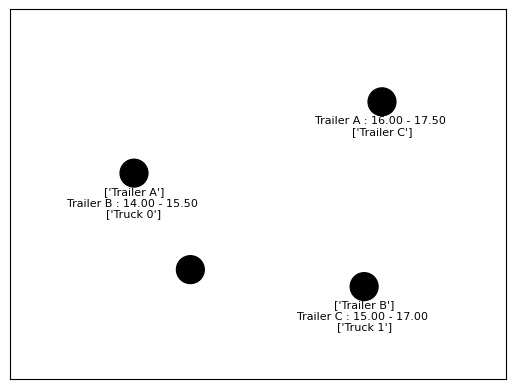

In [19]:
fig, ax = plt.subplots()
G = EVRPGraph(num_nodes=4, num_trailers=3, num_trucks=2, plot_attributes=True)
# add edges that where visited
edges = [
    (0, 3, 'Truck 1', 'Trailer B', 1),
    (0, 3, 'Truck 2', None, 2),
    (3, 2, 'Truck 1', 'Trailer A', 3),
    (3, 2, 'Truck 2', 'Trailer C', 4),
]

print(G._nodes)
G.visit_edge(edges)
G.draw(ax=ax, with_labels=True)

In [25]:
# Init the environment
env = EVRPEnv(num_nodes=20, batch_size=512)

# Init the agent
# agent = EVRPAgent(num_trucks=2, num_trailers=3)

# Start training
# agent.train(env)

TypeError: EVRPEnv.__init__() got an unexpected keyword argument 'num_trucks'